In [60]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# only noiseless functions
from benchmark.bbobbenchmarks import F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12, F13, F14, F15, F16, F21

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

In [61]:
dim = 2
lb, ub = -5, 5

space = RealSpace([lb, ub]) * dim

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

doe_size = 5
max_FEs = 50
verbose = False

In [62]:
opt_color, found_color, initial_color = "green", "red", "blue"


def plot(points, colors, ax=plt, outline=False):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors)
        
def plot_one_function(func, samples, values, results):
    fig, axs = plt.subplots(1, len(results))
    fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
    for (result, ax) in zip(results, axs):
        plot(samples, values, ax=ax, outline=False)
        if result["initial_points"] is not None:
            plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, outline=False)
        ax.set_title(f'{result["description"]}: {result["err"]}', size=6)
        plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, outline=True)
    plt.show()

In [63]:
def test(obj_function, samples, values, found_x, found_value):
    min_x = obj_function._getxopt()
    min_f = obj_function.getfopt()
    transposed = np.transpose(samples)
    min_sampled, max_sampled = values.min(), values.max()
    return {"err": found_value - min_f,
            "opt_x": min_x,
            "opt_f": min_f,
            "found_value": found_value, 
            "found_x": found_x}

In [64]:
def sub_experiment(obj_function, initial_points, test_samples, test_values):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim,
    )

    opt = BO(
        search_space=space,
        obj_fun=obj_function,
        model=model,
        DoE_size=doe_size,
        acquisition_fun="EI",
        initial_points=initial_points,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1,
        log_file="log",
    )
    
    x, value, _ = opt.run()

    test_info = test(obj_function, test_samples, test_values, x, value.item())
    test_info["initial_points"] = opt.initial_points
    return test_info

In [65]:
def experiment(obj_functions, initial_points, n_samples):
    samples = space.sample(n_samples) # test all on the same samples
    results = []
    for obj_function in obj_functions:
        values = obj_function(samples)
        function_results = []
        for (description, points) in initial_points:
            experiment_results = sub_experiment(obj_function, points, samples, values)
            experiment_results["description"] = description
            function_results.append(experiment_results)
        plot_one_function(obj_function, samples, values, function_results)
        results = results + function_results
    return results

In [85]:
obj_functions = (F1(1), F2(1), F3(1), F4(1), F5(1), F6(1), F7(1), F8(1), F9(1), F10(1), F16(1), F21(1))
np.random.seed(10)
initial_points = (
    ("default", None), 
    ("N(mu=0,sigma=1)", np.random.rand(doe_size, dim)),
    (f'N(mu={(mu:=(ub + lb) / 2)},sigma={(sigma:=(mu - lb) / 2)})', np.random.normal(mu, sigma, (doe_size, dim))),
    (f'Uniform({lb}, {ub})', np.random.uniform(lb, ub, (doe_size, dim)))
)

plt.rcParams["figure.figsize"] = (3 * len(initial_points), 3)

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


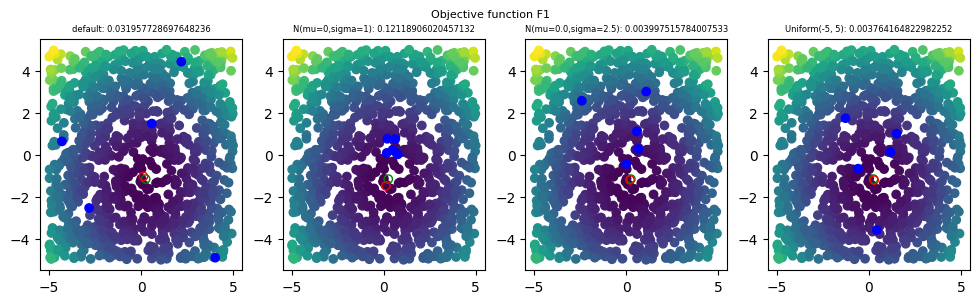

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


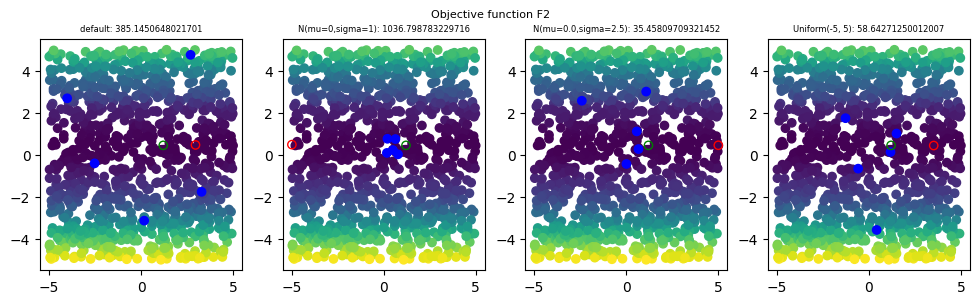

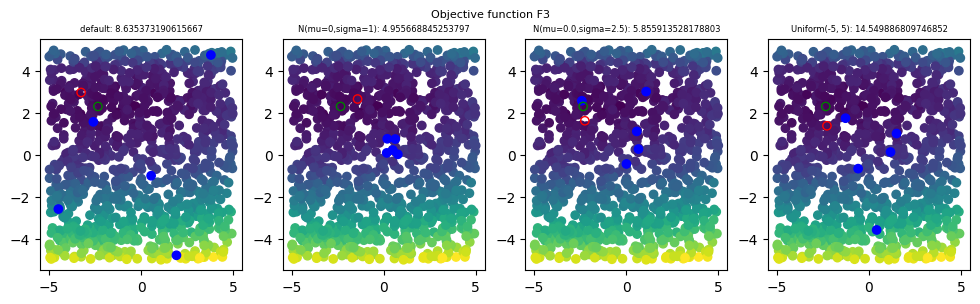

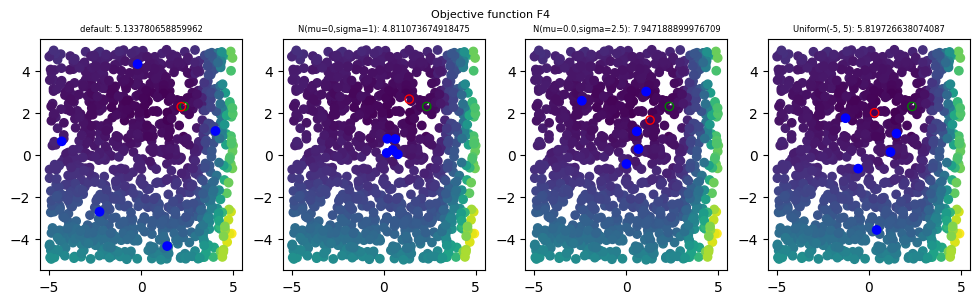

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


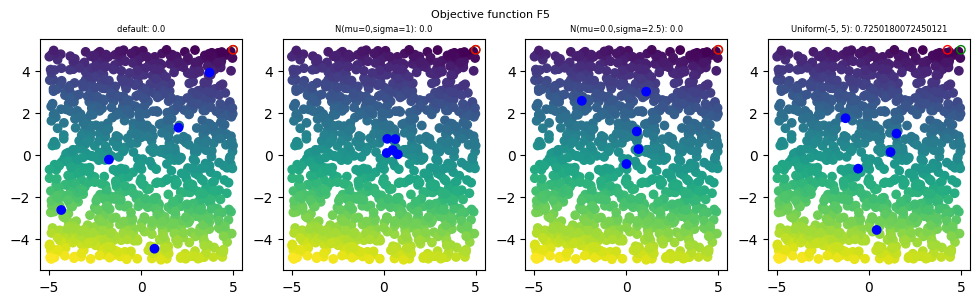

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


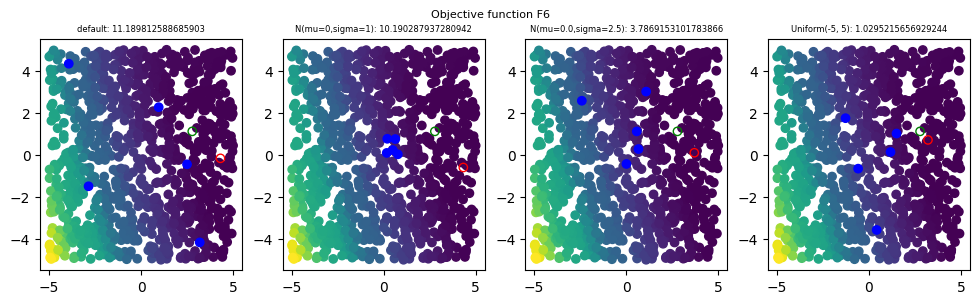

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


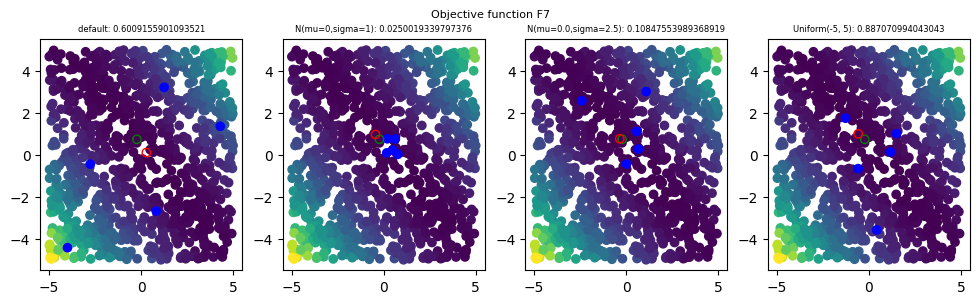

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


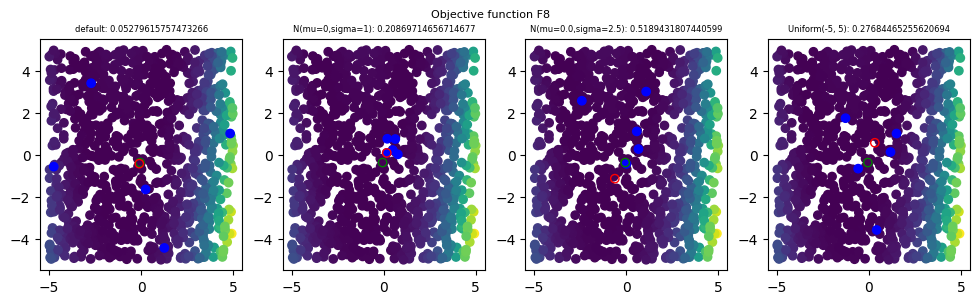

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


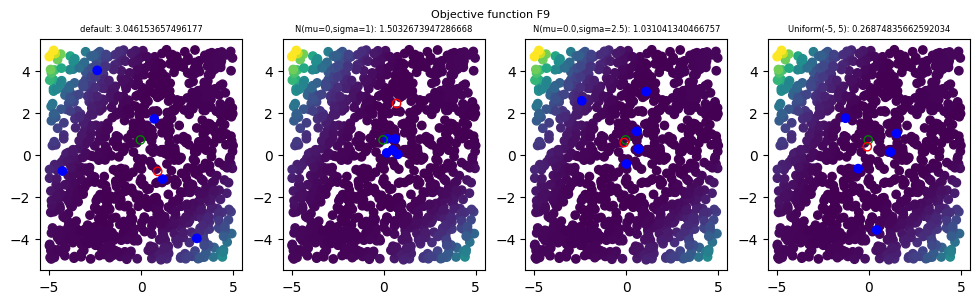

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


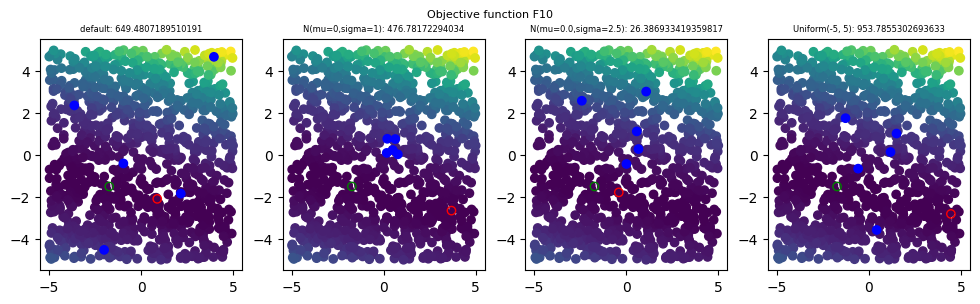

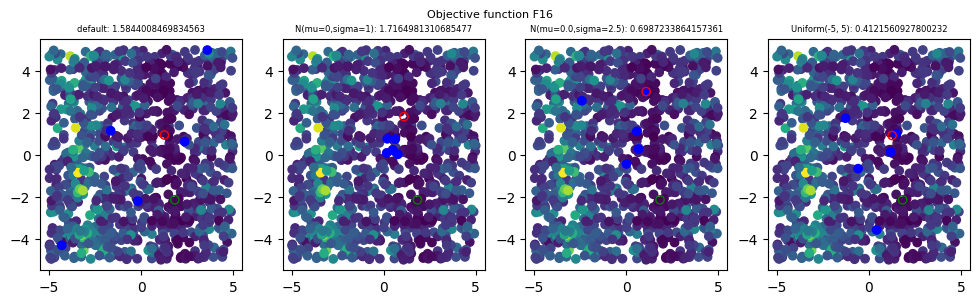

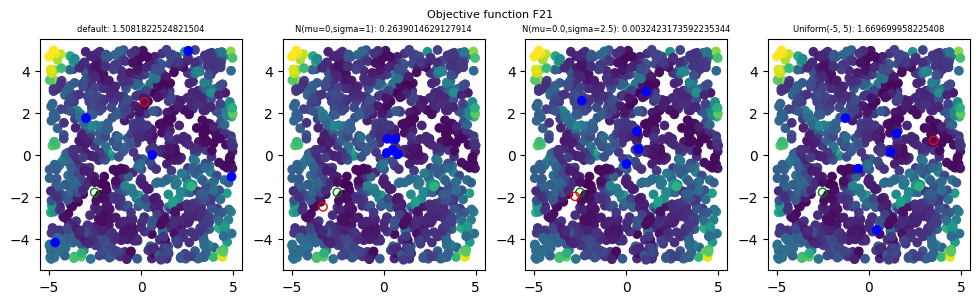

In [86]:
experiment_log = experiment(obj_functions, initial_points, 1000)

In [87]:
# Idea: for each method build a distribution of a normalized error